# Overview
This notebook is a demonstration of how to download data from the OEDI PVDAQ data archives. It is focused on the process for downloading data from the PV Solar Bounty Data Prize sites, that utilize a slightly different archive architecture thatn the rest of the PVDAQ archives. For more information on how to download the other datasets within the PVDAQ archives see the code within the main.py module located inthis same repository.

The PVDAQ Data Archives resides in an Amazon Web Services Simple Storage Solution (S3) bucket. As such, there are modules available to provide you access to this data easily throughthose APIs. This part of the module will focus on the Boto3 module for performing the download.Since this is a series of public datasets, the method does not require the passing of authorization keys.

Steps:
* <a href='#step1'>1. Setup</a>
* <a href='#step2'>2. Download data</a>
* <a href='#step3'>3. Load and plot data from the file</a>

In [ ]:
# if running on google colab, uncomment the next line and execute this cell to install the dependencies and prevent "ModuleNotFoundError" in later cells:
!pip install pvdaq_access

In [1]:
import os
import boto3
import botocore
from botocore.handlers import disable_signing

<a id='step1'></a>

## 1. Setup
The first step is to indicate which system you are wishing to access and where you want the data to be stored. As part of the pvdaq_access module this can be done by passing parameters, but here we will use direct user query. For a list of the prize sites please follow the link [PV Solar Data Prize Sites](https://data.openei.org/s3_viewer?bucket=oedi-data-lake&prefix=pvdaq%2F2023-solar-data-prize%2F)

<div class="alert alert-block alert-info">
<b>System ID for the Webinar:</b> We will be using system 2107.</div>

In [2]:
site = input("Which Solar Bounty Data Prize Site do you wish to access? Enter thier unique ID number: ")
path = ''
if site:
    path = input("Where do you want to download the data to? Enter full path: ")
    if path:
        if os.path.isdir(path):
            print ("Site " + site + " time-series data to be downloaded to " + path)
        else:
            raise OSError('Path ' + path + " does not exists. Please add or cange path and restart.")


Which Solar Bounty Data Prize Site do you wish to access? Enter thier unique ID number: 


In [3]:
if site == '':
    site = '2107'
    
if path == '':
    path = os.getcwd()

<a id='step2'></a>

## 2. Downloading the Data

This next section will connect to the S3 resource for the OEDI and PV Solar Data Bounty sites and pull all the data down from the site to your indicated location.

In [4]:
s3 = boto3.resource("s3")
s3.meta.client.meta.events.register("choose-signer.s3.*", disable_signing)
bucket = s3.Bucket("oedi-data-lake")
print ("Beginning download process ")

#Find each target file in buckets
target_dir = site + '_OEDI'
prefix =  "pvdaq/2023-solar-data-prize/" +  target_dir + "/data/"
objects = bucket.objects.filter(Prefix=prefix)

for obj in objects:
    if obj.key == prefix:
        continue            
    try:
        bucket.download_file(obj.key, os.path.join(path, os.path.basename(obj.key)).replace("\\", "/"))
    except botocore.exceptions.ClientError as e:
        print ('ERROR: Boto3 exception ' + str(e))
    else:
        print ('File ' + os.path.join(path, os.path.basename(obj.key)) + " downloaded successfully.")


Beginning download process 
File C:\Users\sayala\Documents\GitHub\pvdaq_access\tutorials\tutorials\2107_electrical_data.csv downloaded successfully.
File C:\Users\sayala\Documents\GitHub\pvdaq_access\tutorials\tutorials\2107_environment_data.csv downloaded successfully.
File C:\Users\sayala\Documents\GitHub\pvdaq_access\tutorials\tutorials\2107_irradiance_data.csv downloaded successfully.
File C:\Users\sayala\Documents\GitHub\pvdaq_access\tutorials\tutorials\2107_meter_15m_data.csv downloaded successfully.


<a id='step3'></a>

## 3. Load and plot the file

<div class="alert alert-block alert-info">
<b>Select Irradiance Data</b> with file 2107_irradiance_data.csv</div>

In [5]:
print ("File download results")
files = os.listdir(path)
for file in files:
    print(file)

which_file = input("Which file from your download would you like to check? ")

File download results
.ipynb_checkpoints
1 - Downloading Data, and doing a Quality Assessment.py
1 - Solar Bounty Data Prize Data Download.html
1 - Solar Bounty Data Prize Data Download.ipynb
1 - Solar Bounty Data Prize Data Download.py
2 - Download using pvdaq_access.html
2 - Download using pvdaq_access.ipynb
2 - Download using pvdaq_access.py
2107_electrical_data.csv
2107_environment_data.csv
2107_irradiance_data.csv
2107_meter_15m_data.csv
SolarBountyDataPrize_DATA
Which file from your download would you like to check? 


In [6]:
if which_file == '':
    which_file = '2107_irradiance_data.csv'

### Parse file into dataframe and examine info

In [7]:
import pandas as pd
#Read in file
try: 
    df = pd.read_csv(os.path.join(path, which_file))
except FileNotFoundError:
    print("File not found.")
except pd.errors.EmptyDataError:
    print("No data")
except pd.errors.ParserError:
    print("Parse error")
else:
    df.set_index('measured_on', inplace=True)
    #extract file info
    df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 531019 entries, 2017-11-01 07:10:00 to 2023-11-01 23:55:00
Data columns (total 1 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   poa_irradiance_o_149574  531019 non-null  float64
dtypes: float64(1)
memory usage: 8.1+ MB


<a id='step3b'></a>

### Perform a quick plot to examine data

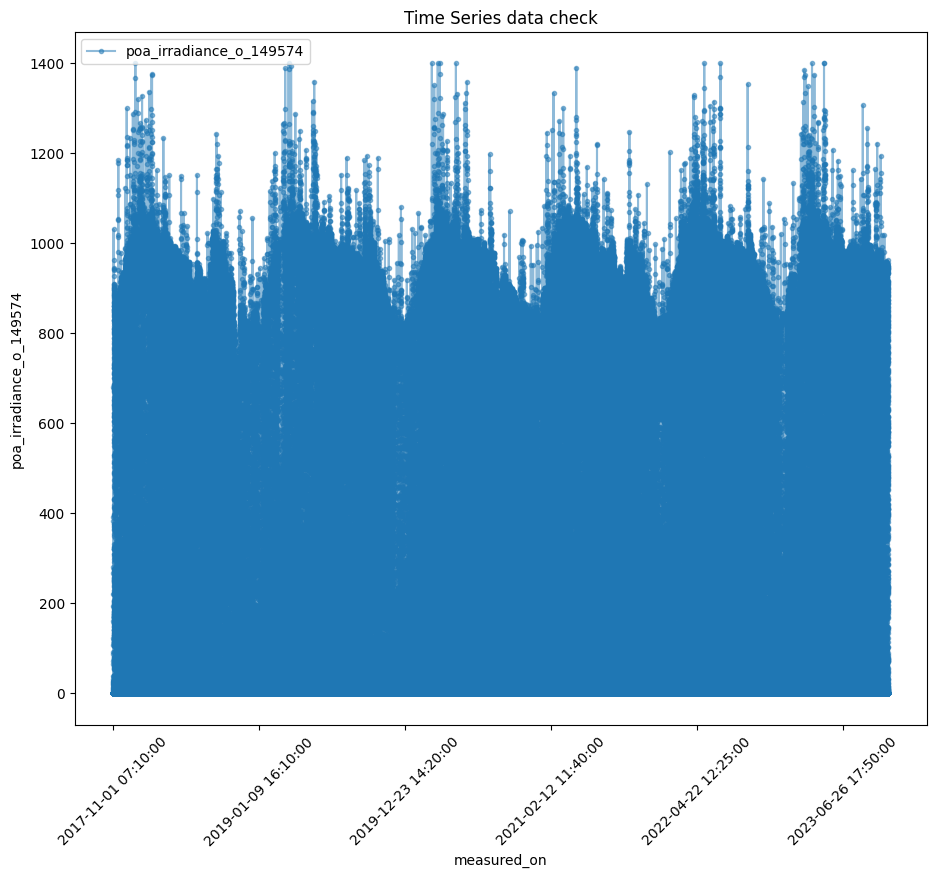

In [8]:
import matplotlib.pyplot as plt

#Set the plot values
plot_cols = ['poa_irradiance_o_149574']

# Add labels and title
axes = df[plot_cols].plot(marker='.', alpha=0.5, figsize=(11, 9))
#Rotate labels               
plt.xticks(rotation=45)    
# Show the plot
plt.xlabel('measured_on')
plt.ylabel('poa_irradiance_o_149574')
plt.title('Time Series data check')
plt.show()